In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_columns = 2000
import tabletext

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['stopwords', 'jigsaw-unintended-bias-in-toxicity-classification', '.DS_Store', 'glove840b300dtxt', 'fasttext-crawl-300d-2m']


In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%reload_ext autoreload

In [37]:
from library.DataSampler import *
from library.PyTorchTrainer import *
from library.ObsceneTextPreprocessor import *
from library.TextTokenizer import *
from library.EvaluationMetrics import *
from library.Reproducibility import *
from library.LSTM import NeuralNet
from library.ExploratoryAnalysis import ExploratoryAnalysis, JigsawExploratoryAnalysis
from library.Embeddings import FastTextEmbeddings

In [23]:
Reproducibility.RANDOM_SEED = 1234
Reproducibility.seed_everything()

In [25]:
fast_text = FastTextEmbeddings('../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec', 100)
print('Embeddings shape: {}'.format(fast_text.shape()))

Embeddings shape: (100, 300)


In [26]:
fast_text.get_all_words()

array([',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that',
       'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was',
       'are', 'or', 'this', 'as', 'have', 'at', 'from', '!', "'s", 'but',
       'by', 'not', '?', 'your', 'all', '/', 'be', 'we', 'my', 'one', '-',
       'will', 'they', 'so', 'which', '”', '“', 'has', '...', 'just',
       'he', 'their', 'can', 'about', 'his', 'our', ';', 'when', 'more',
       'had', 'do', 'some', 'time', 'like', 'also', 'there', 'them',
       'get', 'what', 'out', "'", 'me', 'her', 'an', 'were', 'This', 'It',
       'up', 'would', 'if', 'who', 'new', 'only', 'A', '–', 'people',
       'any', 'We', 'make', 'other', 'In', 'then', 'its', 'use', 'said',
       'now', 'no', 'first'], dtype='<U6')

In [7]:
explore = JigsawExploratoryAnalysis(train_path='../input/train.csv', test_path='../input/test.csv')

In [9]:
data_sampler = DataSampler(explore.train, sample_percent=0.01)

In [10]:
text_processor = ObsceneTextPreprocessor()
clean_comments = text_processor.clean(data_sampler.data()['comment_text'])

In [11]:
tokenizer = TextTokenizer(clean_comments)
tokenised_comments = tokenizer.transform(clean_comments)

In [12]:
# [tokenizer.get_word_by_index(i) for i in tokenised_comments[10] if i > 0]

In [13]:
embeddings, unknown = tokenizer.build_embedding_matrix(fast_text)

Building matrix


In [14]:
X_train, X_test, y_train, y_test =  data_sampler.train_test_split(tokenised_comments, data_sampler.data()['toxic'])

In [15]:
max_features = tokenizer.get_stats()[2] + 1

trainer = PyTorchTrainer(X_train, X_test, y_train, y_test, embeddings, max_features )

Creating tensors
Creating model
Neural Net initialising
Creating embeddings
Creatingg LSTMs
Creating linear
Creating output
Creating datasets


In [16]:
output = trainer.train_model(n_epochs=1)

Training model
[1]
Epoch 1
 102.83%Epoch 1/1 	 loss=0.2861 	 time=162.33s


In [17]:

EvaluationMetrics.compute_auc(y_test, output)


0.5939412546507071

In [18]:
TOXICITY_COLUMN = 'toxic'

def save_score(model_name, data, y_test, output):
    validate_df = data.loc[y_test.index]
    validate_df[model_name] = output
    
    return validate_df

  

In [19]:
validate_df = save_score('M1', data_sampler.data(), y_test, output)

In [20]:
bias_metrics_df = EvaluationMetrics.compute_bias_metrics_for_model(validate_df, explore.identity_columns, 'M1', TOXICITY_COLUMN)
bias_metrics_df


,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
4,0.106011,0.822251,jewish,0.321429,16
0,0.342433,0.710403,male,0.447368,82
3,0.388070,0.771850,christian,0.530303,69
7,0.447934,0.755549,white,0.642857,41
1,0.517871,0.756982,female,0.671429,89
8,0.707656,0.607060,psychiatric_or_mental_illness,0.750000,11
5,0.598230,0.795694,muslim,0.775862,35
2,0.514606,0.831089,homosexual_gay_or_lesbian,0.802632,23
6,0.576473,0.797844,black,0.843537,28


In [21]:
EvaluationMetrics.get_final_metric(bias_metrics_df, EvaluationMetrics.calculate_overall_auc(validate_df, 'M1', TOXICITY_COLUMN))



0.4913532135538389

In [419]:
# explore = JigsawExploratoryAnalysis('../input/train.csv', '../input/test.csv')

In [420]:
# train = explore.train
# test = explore.test

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [ ]:
display(explore.describe_train())

### Sample the train and test data

In [ ]:
train_sample  = explore.train.sample(3)
train_sample

In [ ]:
train_sample['homosexual_gay_or_lesbian'].isnull()

In [ ]:
test.sample(3)

### Train and test stats

In [94]:
test_percent, toxic_comment_distribution = explore.calculate_stats()

In [95]:
print("The train set contains {} number of samples".format(len(explore.train)))
print("The test set contains {} number of samples".format(len(explore.test)))
print("The test set is {0:1f}% of the training set".format(test_percent * 100))
print("The test set contains {} toxic comment".format(explore.train['toxic'].sum().sum()))
print("Toxic comments are {}% of the total comments".format(toxic_comment_distribution * 100))

The train set contains 1804874 number of samples
The test set contains 97320 number of samples
The test set is 5.392066% of the training set
The test set contains 106438 toxic comment
Toxic comments are 5.8972537695152125% of the total comments


### Toxicity distribution

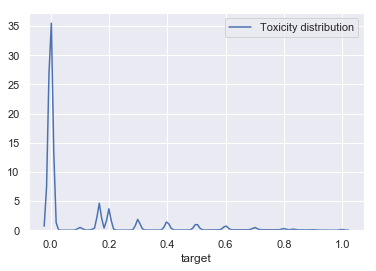

In [65]:
sns.distplot(explore.train['target'], hist=False, kde=True, label="Toxicity distribution")

### Distribution of toxic/non-toxic in the training set

In [59]:

# train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int)



In [98]:
toxic_stats = explore.calculate_toxic_stats_for_identities(threshold=0.0)
    
print(toxic_stats)


                        identity toxic_count  count  toxic_percent na_count
0                           male        8284  80179       0.103319        0
1                         female        7215  73690       0.097910        0
2      homosexual_gay_or_lesbian        2612  15307       0.170641        0
3                      christian        3418  61360       0.055704        0
4                         jewish        1028  10905       0.094269        0
5                         muslim        3731  26650       0.140000        0
6                          black        3745  19563       0.191433        0
7                          white        5350  29948       0.178643        0
8  psychiatric_or_mental_illness        1802  10665       0.168964        0


### Number of samples with no identity

In [99]:
no_identity_train, identity_train = explore.calculate_no_identity_stats()

In [100]:
no_identity_toxic_count = len(no_identity_train[(no_identity_train['toxic'] > 0)])

no_identity_count = len(no_identity_train)

no_identity_toxic_percent = no_identity_toxic_count / no_identity_count

identity_count = len(identity_train)

assert(identity_count  + no_identity_count == len(train))


In [101]:
print("The number of samples with no identity is {}".format(no_identity_count))
print("The number of samples with no identity that are toxic is {}".format(no_identity_toxic_count))
print("The percentage of samples with no identity that are toxic is {0:.2f}% ".format(no_identity_toxic_percent * 100))
print("Train len is {}".format(len(train)))
print("The number of samples with at least one identity is {}".format(identity_count))
print("The percentage of samples with one or more identity set is {0:.2f}%".format(identity_count/len(train) * 100))


The number of samples with no identity is 1594682
The number of samples with no identity that are toxic is 84154
The percentage of samples with no identity that are toxic is 5.28% 
Train len is 1804874
The number of samples with at least one identity is 210192
The percentage of samples with one or more identity set is 11.65%


### Distribution of toxic /non-toxic in subgroups

<span class="q">
    Check subgroups threshold (e.g. 0.5) in Kaggle description
</span>

In [102]:
toxic_subgroup_stats = explore.calculate_toxic_stats_for_subgroups()

print(toxic_subgroup_stats)


          subgroup toxic_count   count  toxic_percent na_count
0  severe_toxicity       57906  104636       0.553404        0
1          obscene       70993  147175       0.482371        0
2           threat       32254  106929       0.301639        0
3           insult      105030  454539       0.231069        0
4  identity_attack       62139  218552       0.284321        0
5  sexual_explicit       24484   68926       0.355222        0


### Is there a correlation between identities

Sample 10000 records and check if there is any evident correlation between identities

In [ ]:
sns.pairplot(explore.train[JigsawExploratoryAnalysis.identity_columns].sample(10000))

### Number of toxic samples

In [103]:
toxic_records = explore.train[explore.train["toxic"] == 1]

In [104]:
len(toxic_records)

106438

### Exploring some toxic comments with special characters

<span class="warn">
    Add table layout
</span>

In [106]:
special_char_toxic = explore.train[(explore.train.comment_text.str.contains('[#$]')) & (explore.train.toxic == 1)]

In [107]:
c = [x for x in special_char_toxic.sample(100).comment_text]

c

["And that's the end of playboy. This is officially their last attempt to be relevant and it's a horrible, miserable failure. Society is going to $hit.",
 "The actual cost is more like $100,000 per day.  its not like the secret service wouldn't be watching him and his family anyway.  What a stupid thing to say.",
 'The shirt should be free and say\n"Bill Walker just stole  $1000 from me and all I got was this stupid T-shirt"',
 'Neither Sask. or Alta planned for the future...all that resource money just piddled away as if the good times would never end.  How is it that the Norwegians managed to save almost 1 trillion $ for future considerations?\nAnd now that the party is over...these fools are standing there with their pockets empty...',
 'Good Read ~ Thanks John ~ POS Seagull Killers for Target Practice These Are Not Hunters They are As*%$#s ~ Be Safe Out There ~ !',
 'Clearly Mr. Carrington has serious personal issues....drugs, alcohol and anger management to name three.  He\'s an e

In [702]:
expr = explore.train['male'] > 0

X_male_train, X_male_test, y_male_train, y_male_test = \
    explore.train_test_split_by_columns(['comment_text'], 'toxic', expr, 0.5)

text_processor = ObsceneTextPreprocessor()


t = TextToIntTransformer(X_male_train['comment_text'], X_male_test['comment_text'])
e = time.time()

32072
8018


### Tokenisation

In [ ]:
# def preprocess(data):
#     '''
#     Credit goes to 
#     https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
#     and
#     https://www.kaggle.com/gromag/simple-lstm-using-identity-parameters-solution
#     '''
#     punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
#     punct = "/-'.,%\'()+-/:;<=>[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    
#     def clean_special_chars(text, punct):
#         for p in punct:
#             text = text.replace(p, ' ')
#         return text

#     data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
#     return data

In [ ]:
# x_test = preprocess(test['comment_text'])
# x_train = preprocess(train['comment_text'])

In [39]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
import re
#Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giusepperomagnuolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
# #Use the English stopword list
stop_words = set(stopwords.words('english'))
# #Add additional stopwords to our set
stop_words.update()
tokenizer = RegexpTokenizer(r'[\%\@\&\$\#\w\!\*]+')

leave_words = ['i', 'you', 'myself', 'yourself', 'no', 'she', 'themselves', 'he', 'we', 'only', 'up', 'your', 'my', 'mine', 'yours', 'hers', 'her', 'his']

stop_words_amended = [w for w in stop_words if (not w in leave_words)]

#Tokenise text removing stopwords and digits
def tokeniseDoc(doc):    
    out = [w.lower() for w in tokenizer.tokenize(doc) if (not w.lower() in stop_words_amended) and not re.search("\d+", w) ]
    return out

clean_comments = [ tokeniseDoc(doc) for doc in data_sampler.data()['comment_text']]





### Comments using special characters

Special characters might indicate camuflaged swear words.

In [569]:
# dollar =[c for c in clean_comments if len([w for w in c if re.search('\$', w)]) > 0 ]

dollar =[c for c in clean_comments if re.search('\$', c) ]

In [570]:
dollar[0:10]

['Perhaps voter fraud 2016 else would reality show host phony $3 bill get elected president',
 'My APPL I sold recently bought new car I first bought $14 split x8 since',
 'Sure Government Canada 5 year bond according Cat math almost guaranteed rise current 0 949% yield 4 3% within two years! lottery like 350% return bet two years you somehow think reasonable assumption WOW! Tell you ever seen prognosticated your crystal ball yields going roof happened gold $5 000 oz shortly oops no ENB drop $20 per share bad far we still seven weeks go guarantee yours BMO wll trade $80 share debt equity ratio might atrocious only you company high risk business obvious ENB fact low risk conservatively run business you note ENB debt equity ratio fallen risk Your ENB meltdown 12 31 15 $46 today $53 51 including divs PLUS 16 3% 22% cat meltdown wow',
 'I feel somewhat inappropriate 80 year old I would still replying RoB failing specifically address issues around capital preservation income seniors article

In [32]:
train_path = '../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv'
test_path = '../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv'


explore = JigsawExploratoryAnalysis(train_path=train_path, test_path=test_path)

In [48]:
data_sampler = DataSampler(explore.train, sample_percent=0.3)

In [33]:
from keras.preprocessing import text, sequence

In [34]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(data_sampler.data()))
MAX_LEN = 220

# x_train = tokenizer.texts_to_sequences(explore.train)
# x_test = tokenizer.texts_to_sequences(explore.test)
# x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
# x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

NameError: name 'x_train' is not defined

In [ ]:
# tokenizer.word_counts

### Number of words per sample

In [50]:
document_lengths = [len(tokens) for tokens in clean_comments]


In [43]:
from collections import Counter
# Retrieving some documents' stats

# Extracting all words
all_words = [word for tokens in xts for word in tokens]

# Creating our Vocabulary, a distinct list of words 
VOCAB = sorted(list(set(all_words)))

# Counting the length of each document
document_lengths = [len(tokens) for tokens in clean_comments]

#Counting the frequency of each word
count_all_words = Counter(all_words)

NameError: name 'xts' is not defined

### Frequency distribution of words

In [ ]:
# To be done

### Distribution of sample length

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

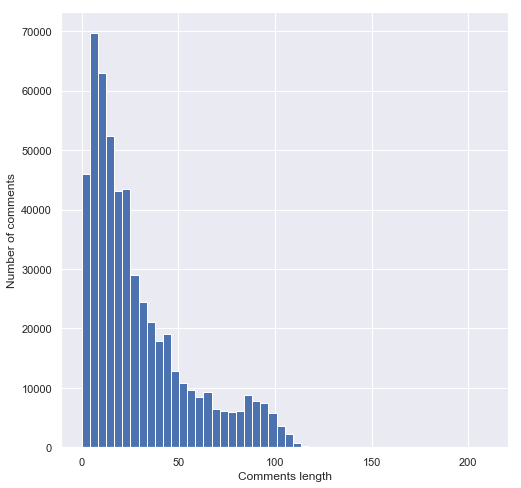

In [59]:
fig = plt.figure(figsize=(8, 8)) 
plt.xlabel('Comments length')
plt.ylabel('Number of comments')
plt.hist(document_lengths, bins=50)
plt.show()

In [ ]:
VOCAB = sorted(list(set(all_words)))
print("{:,} words total, with a vocabulary size of {:,}".format(len(all_words), len(VOCAB)))

### Most frequent words

Most frequent words

In [ ]:
# get the top 10 most common occuring words skipping the first 10
print(tabletext.to_text([('TERM', 'COUNT'), *count_all_words.most_common(10)]))

Most frequent words skipping the first 10 as those are stop words

In [ ]:
# get the top 10 most common occuring words skipping the first 10
print(tabletext.to_text([('TERM', 'COUNT'), *count_all_words.most_common(100)][11:21]))

## Most common words found in toxic but not in non-toxic

In [ ]:
from collections import Counter

def extract_words(df, comments, expr):
    c = np.array(comments)
    toxic_comments = c[expr]
    fr = {}
    words = [w for c in toxic_comments for w in c]
    return Counter(words)



In [ ]:
word_in_toxic = extract_words(train, clean_comments, (train['toxic'] == 1))
word_in_non_toxic = extract_words(train, clean_comments, (train['toxic'] == 0))

In [ ]:
word_in_toxic.most_common(10)

In [ ]:
word_in_non_toxic.most_common(10)

In [ ]:
word_in_non_toxic['iasdfaf']

### Words found in toxic but not in non-toxic

In [ ]:
words_in_toxic_not_in_non_toxic = Counter([w for w in word_in_toxic if word_in_non_toxic[w] == 0])

In [ ]:
print(words_in_toxic_not_in_non_toxic.most_common(100))
print(len(words_in_toxic_not_in_non_toxic)/len(train[(train['toxic'] > 0.5)]))

### Words found in non-toxic but not in toxic

In [ ]:
words_in_non_toxic_not_in_toxic = Counter([w for w in word_in_non_toxic if word_in_toxic[w] == 0])

In [ ]:
print(words_in_non_toxic_not_in_toxic.most_common(100))
print(len(words_in_non_toxic_not_in_toxic)/len(train[(train['toxic'] == 0.0)]))

In [ ]:
def count_frequency(word_list):
    # Get a set of unique words from the list
    word_set = set(word_list)
    # create your frequency dictionary
    freq = {}
    # iterate through them, once per unique word.
    for word in word_set:
        freq[word] = word_list.count(word) / float(len(word_list))
        
    return freq

In [ ]:
toxic_word_freq = count_frequency(words_in_toxic_not_in_non_toxic)

## Evaluation Metrics

Thanks to https://www.kaggle.com/gromag/benchmark-kernel/edit/run/12870543

### Define bias metrics, then evaluate our new model for bias using the validation set predictions

### Calculate the final score

In [ ]:
# bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
# bias_metrics_df    
# get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

In [ ]:
train['dummy_model'] = 0

In [ ]:


EvaluationMetrics.compute_bias_metrics_for_model(train, explore.identity_columns, 'dummy_model', 'toxic')


In [ ]:
%%html
<style>
    .q {
        color: red;
    }
</style>

In [ ]:
class A: x = 'a'

class B(A): pass

class C(A): x = 'c'
    
class D(B, C): pass

D.x

## Splitting the data by identity and creating train and test sets

In [ ]:
from sklearn import model_selection

dataByIdentity = {}

for col in explore.identity_columns:
    relevant_samples = train[train[col] > 0.5]
    train_df, validate_df = model_selection.train_test_split(relevant_samples, test_size=0.2)
    dataByIdentity[col] = {'train': train_df, 'validate': validate_df }

In [ ]:
for col in explore.identity_columns:
    print(EvaluationMetrics.compute_bias_metrics_for_model(dataByIdentity[col]['train'], explore.identity_columns, 'dummy_model', 'toxic'))



In [5]:
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [18]:
drop = nn.Dropout(p=0.9)
x = torch.ones(1, 10)

print(x)

# Train mode (default after construction)
drop.train()
print(drop(x))

# Eval mode
drop.eval()
print(drop(x))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [25]:
import random

class foo():
    
    def __init__(self):
        super().__init__()
    
    def train(self):
        
        v = []
        
        def f(n):
            v.append(n)
            
        
        self.pred(f)

        
        return v
        
    def pred(self, fn):    
        for i in range(10):
            fn(random.randint(1,10))
        
        
a = foo()

a.train()



[9, 8, 2, 9, 6, 2, 4, 8, 5, 1]

In [ ]:
n_epochs = 5

In [ ]:
a = np.array([2 ** epoch for epoch in range(n_epochs)])

In [ ]:
a = np.where(a > 4, 1, 0)

In [ ]:
a

In [ ]:
a[:, np.newaxis]

In [ ]:
a = np.hstack([a[:, np.newaxis], np.array([[2],[2],[2],[2],[2]])])

In [ ]:
a.shape[-1]

In [ ]:
a[:,-1]

In [ ]:
a[-1]

In [ ]:
a

In [ ]:
a[-1]

In [ ]:
F.max_pool2d()